# Predicting Usage of a Video Game Research Server - Final Report

`project-004-12`
- Neil Zhu
- Peti Setabandhu (41047416)
- Tuna Sayin
- Tiangxiang Song (54550017)

Link to GitHub repo: https://github.com/peteseta/dsci-100-project

In [98]:
library(tidyverse)
library(tidymodels)
library(repr)
library(janitor)
library(GGally)

options(repr.matrix.max.rows = 6)

## Introduction

PLAIcraft is a research server for the popular game Minecraft, designed to collect behavioral data from players for academic studies. The server's success depends on recruiting players who will contribute substantial playtime and generate rich datasets, as this research will require large datasets of player behavior to draw meaningful conclusions.

Understanding which types of players are most likely to engage deeply with the server is crucial for efficient recruitment - by analyzing demographic information and self-reported experience levels, we can identify characteristics associated with high engagement.

Our **research question** is thus can player demographic characteristics (age, gender, experience level, newsletter subscription status) predict the total hours played on the PLAIcraft server?

This falls under the broad question
> Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

We first take an initial look at the data:

In [99]:
players <- read_csv("https://raw.githubusercontent.com/peteseta/dsci-100-project/refs/heads/main/data/players.csv")

head(players)
summary(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

### Dataset description

We analyzed the `players.csv` dataset, which contains information about 196 registered PLAIcraft players. The dataset includes 196 observations with the following 7 variables:

- `experience` (categorical): Player's self-reported experience level - "Beginner", "Amateur", "Regular", "Pro", or "Veteran"
- `subscribe` (logical): Whether the player subscribed to the server newsletter (TRUE/FALSE)
- `hashedEmail` (character): Anonymized identifier for each player
- `played_hours` (numeric): Total playtime on the server in hours
- `name` (character): Player's username
- `gender` (categorical): Player's self-reported gender
- `Age` (numeric): Player's age in years

We initially noted some issues with the data, including missing values in the `Age` variable and a large number of players with zero recorded playtime (indicating they registered but never played).

## Methods and results:
<!-- - describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
    - loads data
    - wrangles and cleans the data to the format necessary for the planned analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    - performs the data analysis
    - creates a visualization of the analysis
note: all figures should have a figure number and a legend -->

### Data loading, wrangling, and exploratory analysis
We begin by wrangling the data such that the column names are consistent, experience and gender are properly treated as factors, and that we remove observations with missing values.

In [100]:
# wrangle data
# clean names, convert to factors, remove missing values
players_clean <- players |>
    clean_names() |>
    mutate(
        experience = factor(experience,
                            levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")),
        gender = factor(gender)
    ) |>
    drop_na()

players_clean

# summary of cleaned dataset
cat("original observations:", nrow(players), "\n")
cat("after removing NA values:", nrow(players_clean), "\n")

experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


original observations: 196 
after removing NA values: 194 


Two rows containing missing data were removed. Then, we perform an exploratory data analysis, calculating summary statistics for each numerical column and counts for each categorical column.

In [101]:
# EDA
summary_stats <- players_clean |>
    summarize(
        mean_played_hours = mean(played_hours, na.rm = TRUE),
        median_played_hours = median(played_hours, na.rm = TRUE),
        sd_played_hours = sd(played_hours, na.rm = TRUE),
        mean_age = mean(age, na.rm = TRUE),
        median_age = median(age, na.rm = TRUE),
        sd_age = sd(age, na.rm = TRUE)
    )

summary_stats

experience <- players_clean |>
    count(experience)

gender <- players_clean |>
    count(gender)

subscribe <- players_clean |>
    count(subscribe)

experience
gender
subscribe

mean_played_hours,median_played_hours,sd_played_hours,mean_age,median_age,sd_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.904639,0.1,28.49793,21.13918,19,7.389687


experience,n
<fct>,<int>
Beginner,35
Amateur,63
Regular,35
Pro,13
Veteran,48


gender,n
<fct>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Prefer not to say,11
Two-Spirited,5


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,142


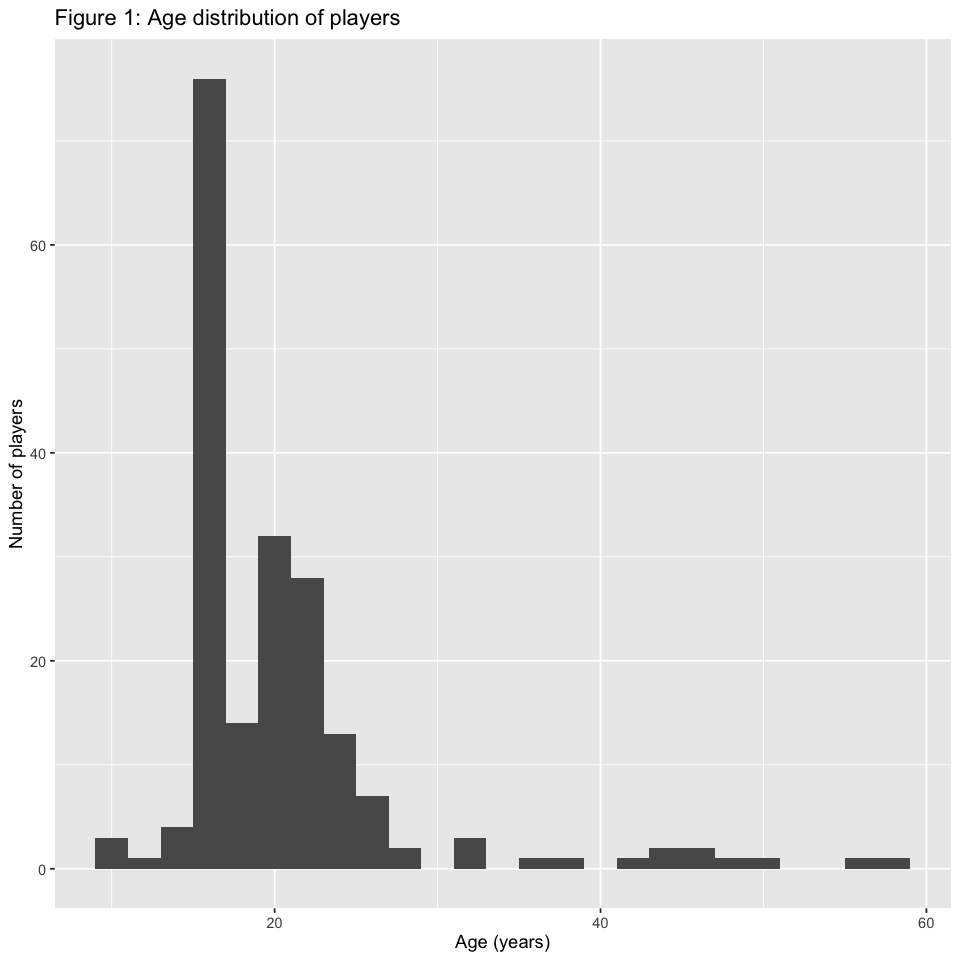

In [102]:
# visualization 1 - age distribution
options(repr.plot.width = 8, repr.plot.height = 8)

age_dist <- ggplot(players_clean, aes(x = age)) +
  geom_histogram(binwidth = 2) +
  labs(
    title = "Figure 1: Age distribution of players", 
    x = "Age (years)", 
    y = "Number of players")

age_dist

From _Figure 1_ and the summary data, we observe that the majority of players are young adults aged 15-25 years, with a mean age of 21.1 years. There are a few older outliers (up to 58 years), but these represent a small minority of the player base.


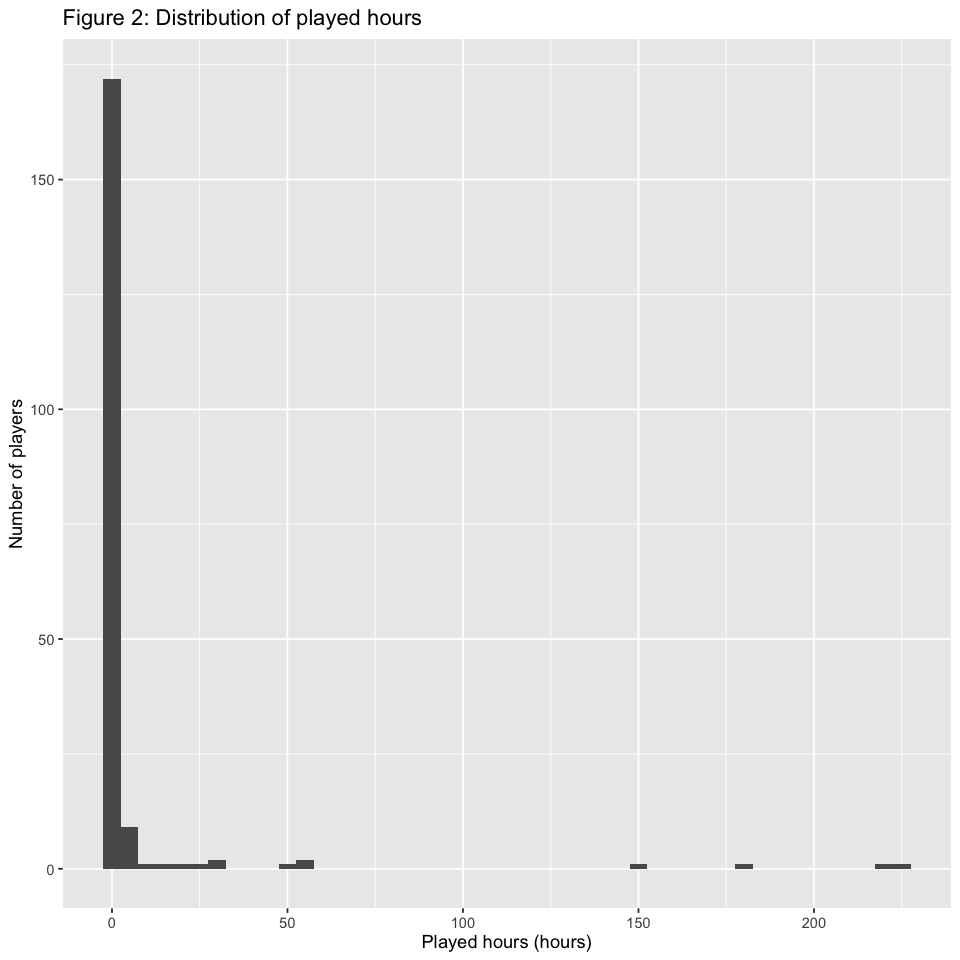

In [103]:
# visualization 2 - played hours distribution
ggplot(players_clean, aes(x = played_hours)) +
  geom_histogram(binwidth = 5) +
  labs(
    title = "Figure 2: Distribution of played hours", 
    x = "Played hours (hours)", 
    y = "Number of players")

From _Figure 2_, we observe that the distribution is heavily right-skewed. Most players (modal bin: 0-5 hours) registered but played minimally or not at all. A small number of highly engaged outliers contributed 50-223 hours of playtime. This suggests that recruitment efforts should focus on identifying the characteristics of these highly engaged players.

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


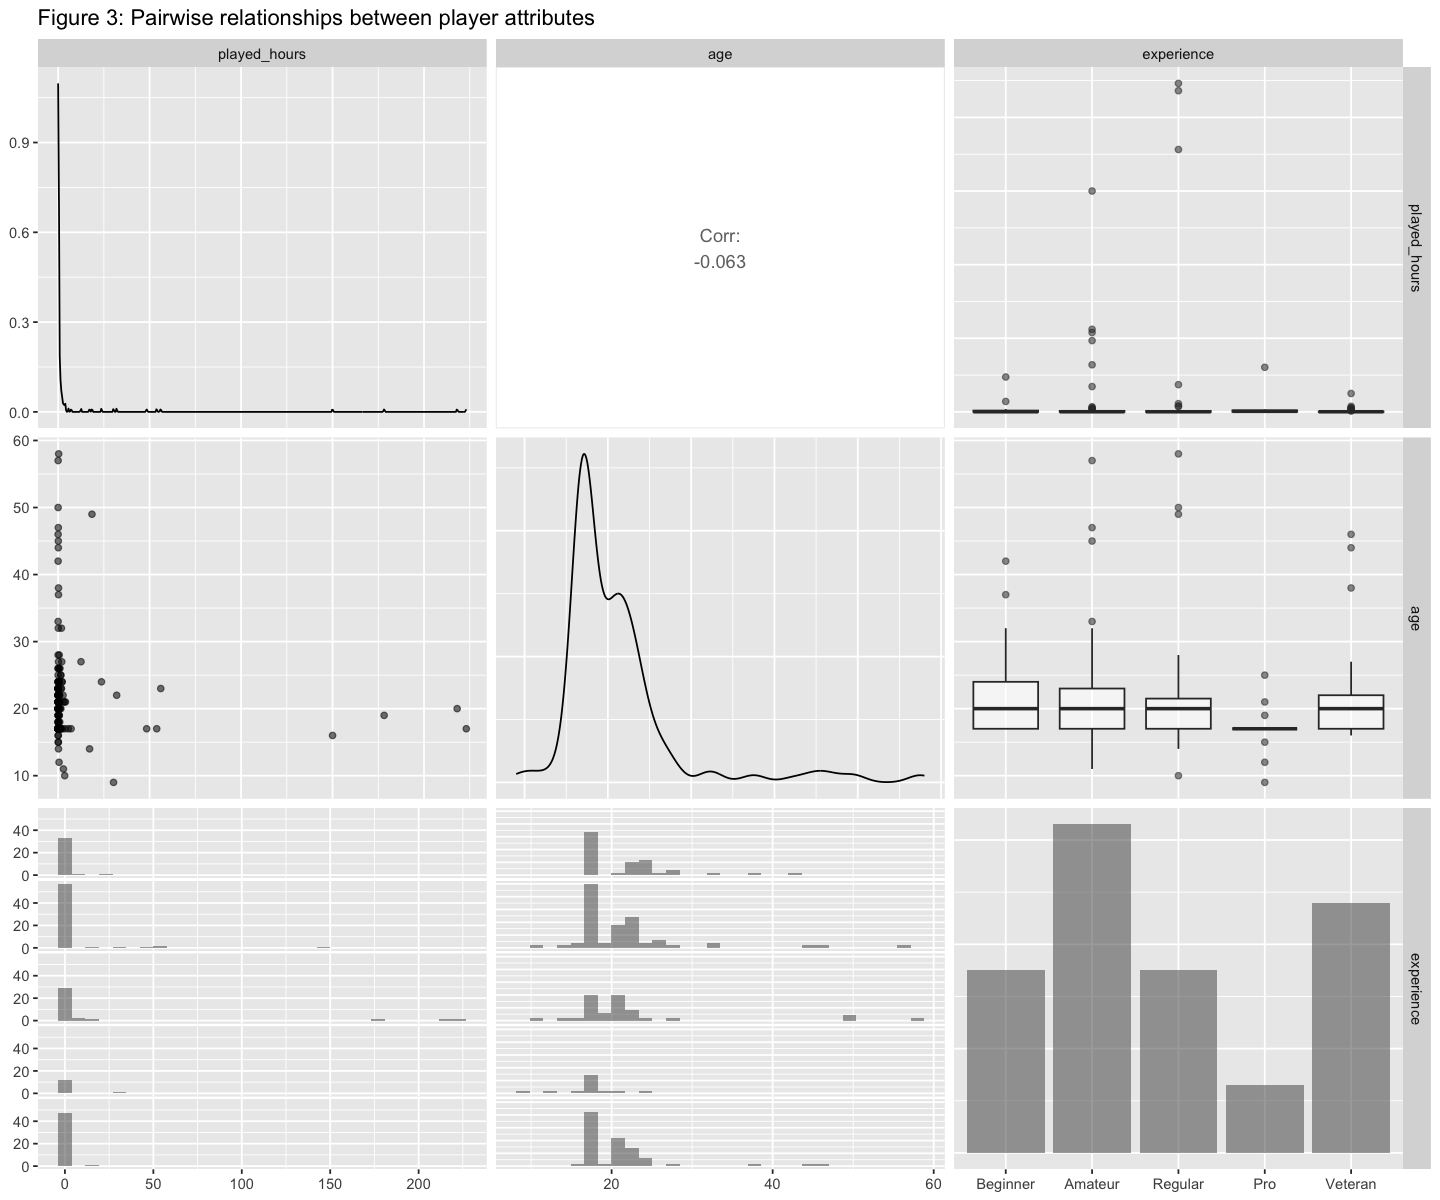

In [104]:
# visualization 3 - pairwise relationships
options(repr.plot.width = 12, repr.plot.height = 10)

pairplot <- players_clean |>
    select(played_hours, age, experience) |>
    ggpairs(
        mapping = aes(alpha = 0.4),
        upper = list(continuous = "cor", combo = "box_no_facet"),
        lower = list(continuous = "points", combo = "facethist")
    ) +
    labs(
        title = "Figure 3: Pairwise relationships between player attributes",
    )

pairplot

From the pairwise relationships in _Figure 3_, we can see that:
- Experience level appears roughly independent of age
- The highest playtime outliers tend to be in the 15-20 age range
- Players over 25 years old almost exclusively played fewer than 25 hours
- "Amateur" is the most common experience level, followed by "Veteran"

These exploratory findings suggest that younger players and certain experience levels may be associated with higher engagement, which we will investigate further through predictive modeling.

### Model training

To answer the research question, we train a regression model to predict `played_hours` based on the demographic variables: `age`, `gender`, `experience`, and `subscribe`.

We begin by splitting the data (stratifying by `played_hours` to ensure balanced representation) and creating the recipe.

In [105]:
# split data
set.seed(123)

data_split <- initial_split(players_clean, prop = 0.8, strata = played_hours)

train_data <- training(data_split)
test_data  <- testing(data_split)

The K-NN algorithm requires numeric input features to calculate Euclidean distance.
- Since subscription is a logical variable, we convert it to a numeric value.
- Since gender and experience are factors, we create dummy variables for each level and give it each a numeric value.

We then standardize all numeric predictors to have mean 0 and standard deviation 1.

In [106]:
# k-nn recipe and preprocessing
knn_recipe <- recipe(played_hours ~ age + gender + experience + subscribe,
                     data = train_data) |>
  step_mutate(subscribe = as.integer(subscribe)) |>  # logical to numeric
  step_dummy(all_nominal_predictors()) |>  # dummy variables for gender and experience
  step_normalize(all_predictors())  # normalize everything

knn_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Operations 

• Variable mutation for: as.integer(subscribe)

• Dummy variables from: all_nominal_predictors()

• Centering and scaling for: all_predictors()



#### Cross-validation for parameter selection

We then perform 5-fold cross-validation on the training set to select the optimal value of k (number of neighbors).

In [117]:
# k-nn model specification for tuning
knn_spec <- nearest_neighbor(
    neighbors = tune(),
    weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("regression")

In [119]:
# k-nn workflow for tuning
tuning_workflow <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(knn_recipe)

In [122]:
# tune model
# 5-fold cross validation
folds <- vfold_cv(train_data, v = 5, strata = played_hours)

tune_results <- tune_grid(
  tuning_workflow,
  resamples = folds,
  grid = tibble(neighbors = seq(1, 50, by = 1))
)

tune_metrics <- tune_results |>
    collect_metrics()

tune_metrics

→ A | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_Other.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x4

There were issues with some computations   A: x5





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,29.710962126,5,8.752768150,pre0_mod01_post0
1,rsq,standard,0.004009325,5,0.001954829,pre0_mod01_post0
2,rmse,standard,26.322154116,5,8.217575366,pre0_mod02_post0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,rsq,standard,0.03032002,5,0.01130010,pre0_mod49_post0
50,rmse,standard,23.63475964,5,8.42911627,pre0_mod50_post0
50,rsq,standard,0.03101278,5,0.01142781,pre0_mod50_post0


neighbors,.config
<dbl>,<chr>
48,pre0_mod48_post0


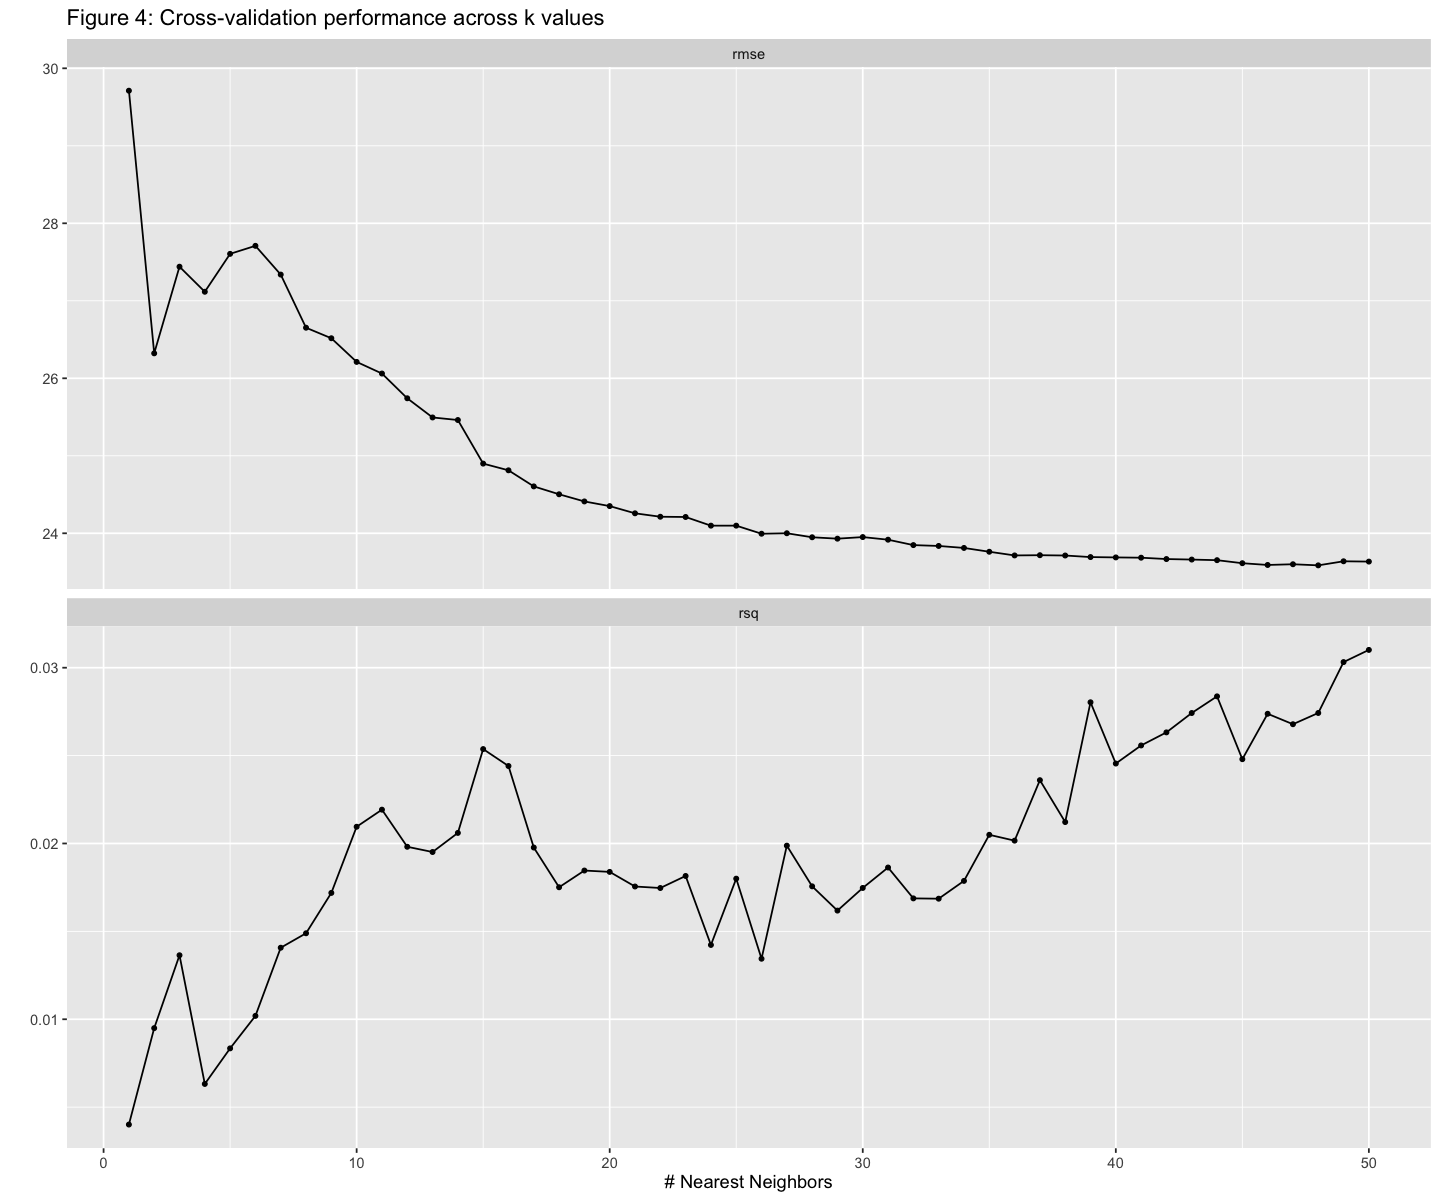

In [123]:
# visualize optimal k value
autoplot(tune_results) +
    labs(title = "Figure 4: Cross-validation performance across k values")

best_k <- select_best(tune_results, metric = "rmse")
best_k

From _Figure 4_, we observe that:
- RMSE decreases as the number of neighbors increases. Very small K values (K=1-2) perform poorly due to overfitting. The RMSE shows some volatility in the `K=2-15` range before stabilizing around `K=20-50` at approximately 23.5-24 hours. So, larger K values provide more stable predictions by averaging over more neighbors.
- However, R-squared values remain very low throughout the entire range (< 0.04). So, the model explains less than 4% of the variance in played hours, suggesting that the predictive variables (age, gender, experience, subscription) have very weak predictive power for player engagement.
- Based on minimizing RMSE, the optimal K value is 48 neighbors.

#### Modeling with the optimal k-value

Now that we have the optimal k-value from cross-validation, we can fit the final K-NN model on the training set and evaluate its performance on the test set.

In [111]:
# k-nn model specification and workflow with optimal k value
final_workflow <- tuning_workflow |>
    finalize_workflow(best_k)

final_fit <- final_workflow |>
    fit(data = train_data)

Warning message:
“!  The following column has zero variance so scaling cannot be used:
  gender_Other.
ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
  before normalizing.”


### Model evaluation

In [112]:
# metrics on test set
test_predictions <- final_fit |>
  predict(test_data) |>
  bind_cols(test_data)

test_metrics <- test_predictions |>
  metrics(truth = played_hours, estimate = .pred)

test_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,27.26287466
rsq,standard,0.07424274
mae,standard,9.31700000


Evaluating the final model on the test set, we obtain:
- Root-mean-square prediction error (RMSPE): 27.26 hours
- R-squared: 0.074 = 7.4%

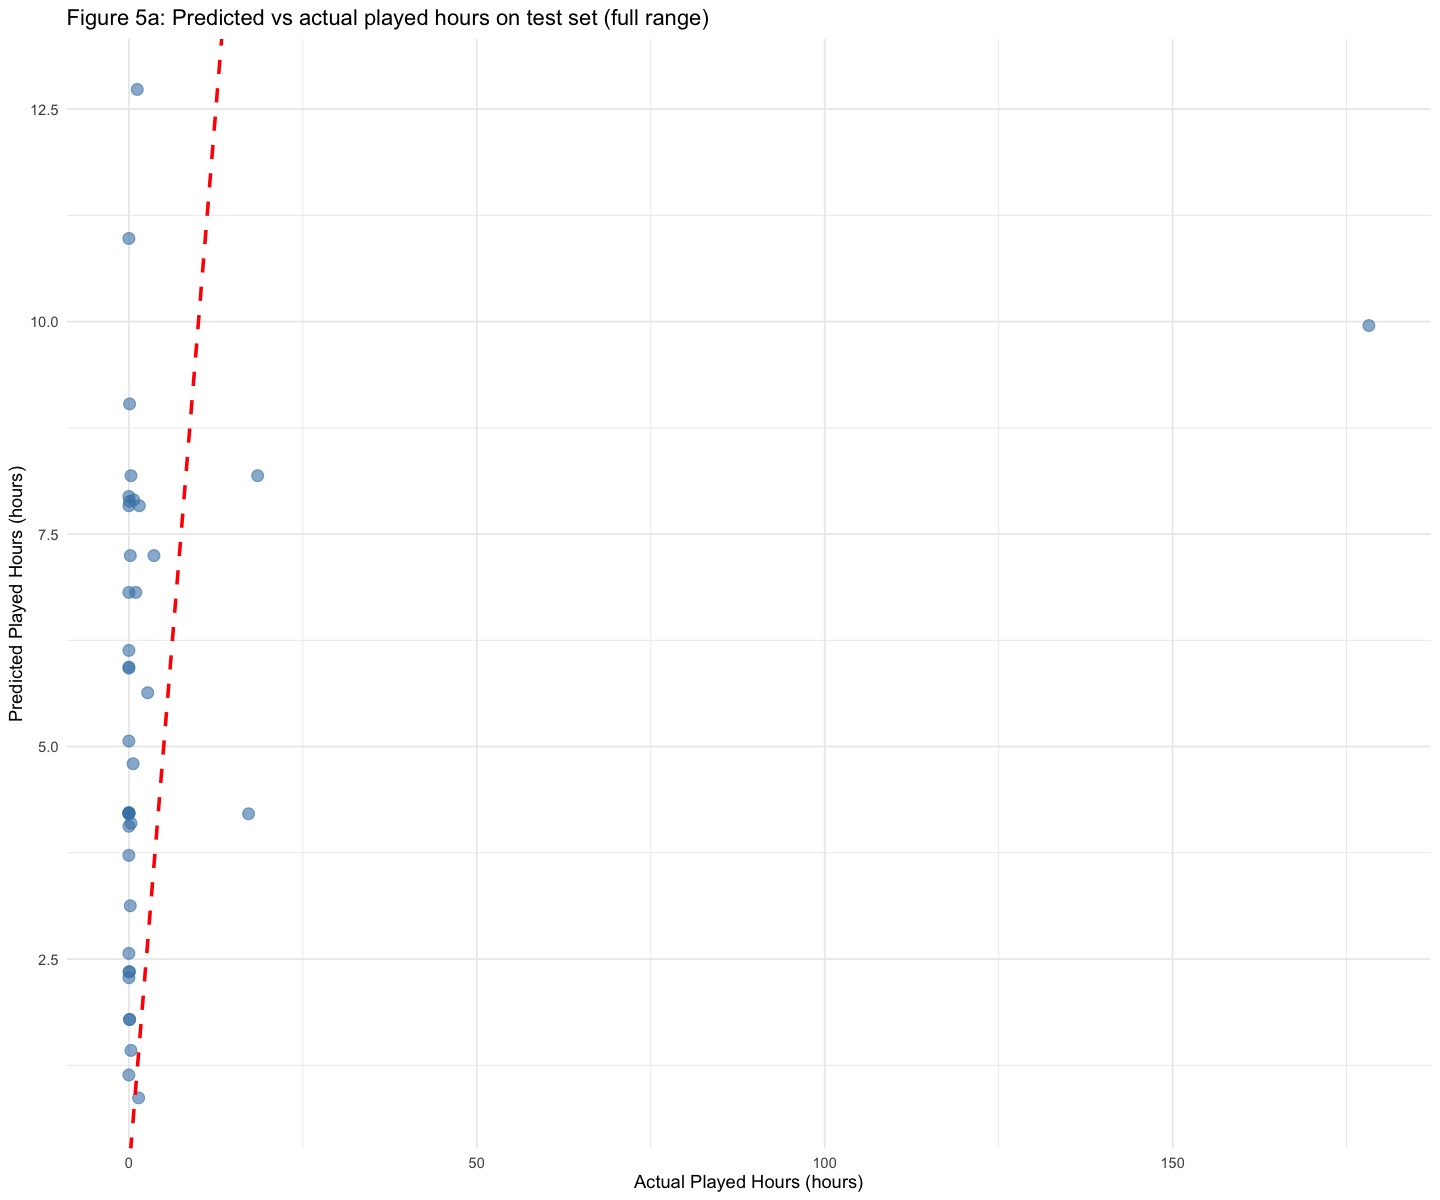

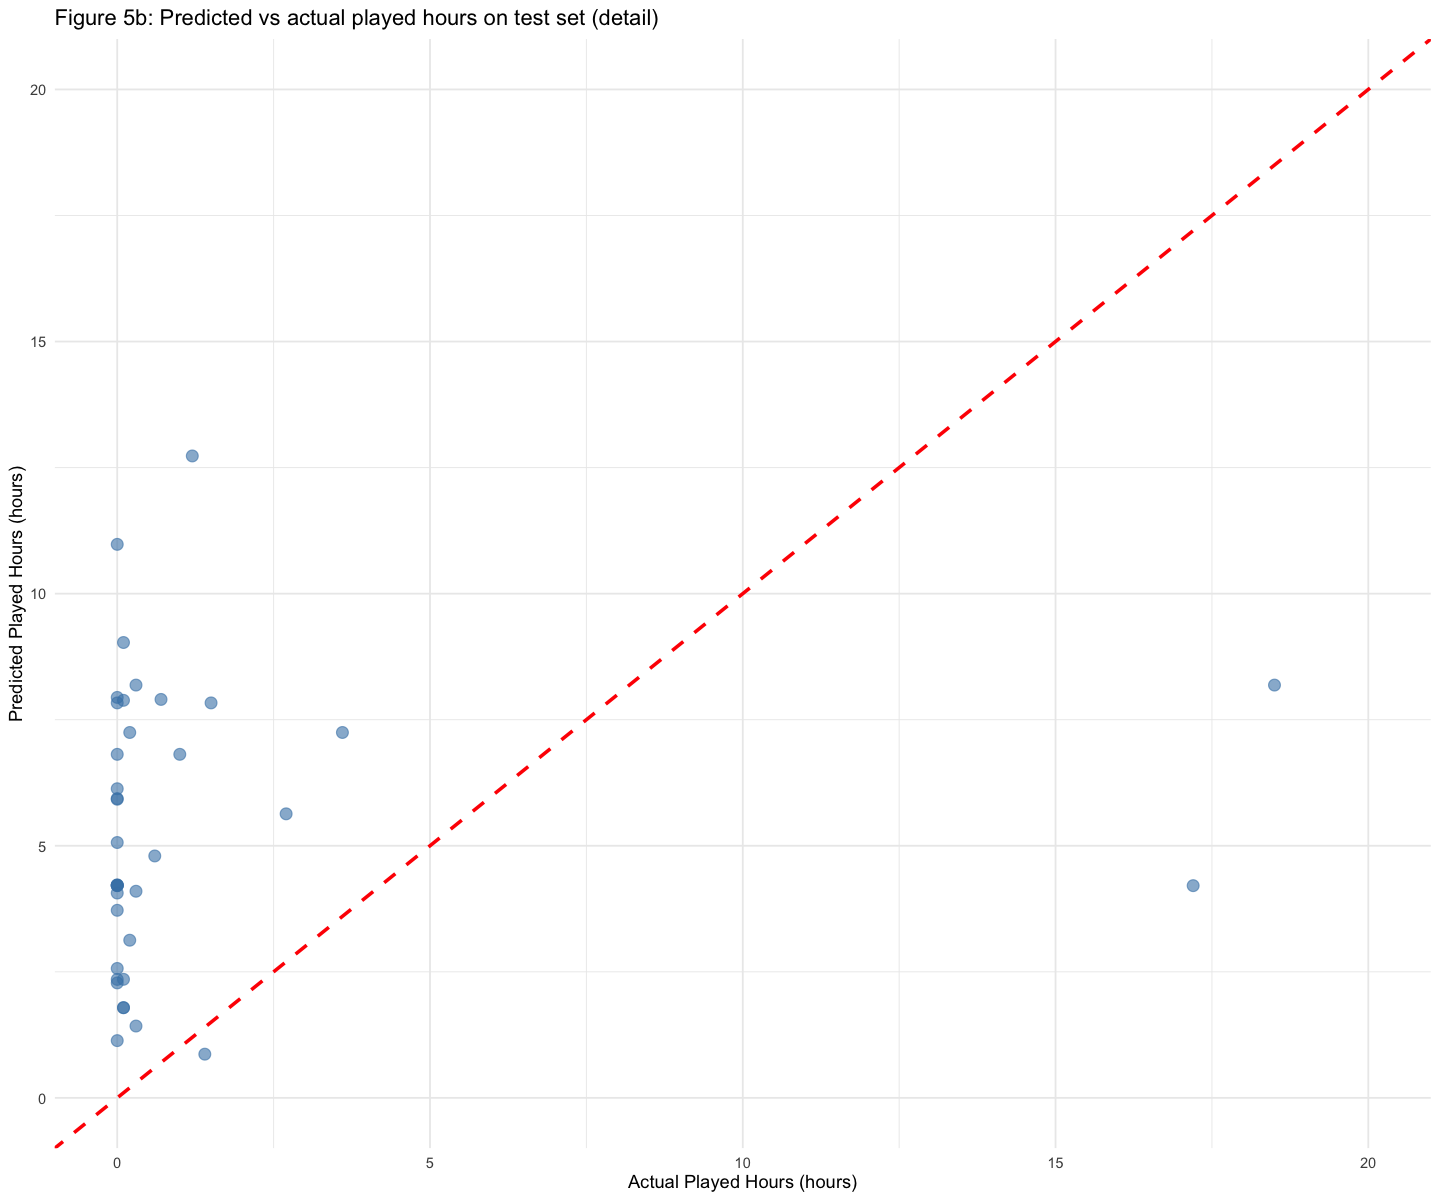

In [113]:
# visualization of predicted vs actual

# full range plot w that one outlier
predictions_plot_full <- test_predictions |>
    ggplot(aes(x = played_hours, y = .pred)) +
    geom_point(alpha = 0.6, size = 3, color = "steelblue") +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red", size = 1) +
    labs(
        title = "Figure 5a: Predicted vs actual played hours on test set (full range)",
        x = "Actual Played Hours (hours)",
        y = "Predicted Played Hours (hours)"
    ) +
    theme_minimal()

# zoomed in plot for the 0-50 hour range
predictions_plot_zoom <- test_predictions |>
    ggplot(aes(x = played_hours, y = .pred)) +
    geom_point(alpha = 0.6, size = 3, color = "steelblue") +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red", size = 1) +
    coord_cartesian(xlim = c(0, 20), ylim = c(0, 20)) +
    labs(
        title = "Figure 5b: Predicted vs actual played hours on test set (detail)",
        x = "Actual Played Hours (hours)",
        y = "Predicted Played Hours (hours)"
    ) +
    theme_minimal()     

predictions_plot_full
predictions_plot_zoom

_Figure 5a_ reveals that while predictions cluster in a reasonable range (roughly 2-13 hours) for most test observations, the model completely fails to predict high-engagement outliers. 
- For instance, the player with approximately 200 actual hours is predicted to play only about 10 hours. 
- If predictions were accurate, points would fall along the red diagonal line.

_Figure 5b_ provides a detailed view of the 0-20 hour range where most players cluster. 
- Even in this typical range, predictions show considerable scatter around the ideal diagonal. 
- The model tends to predict values between 5-13 hours regardless of whether actual values are near 0 or near 20, which shows a poor ability to discriminate between engagement levels even among typical players.

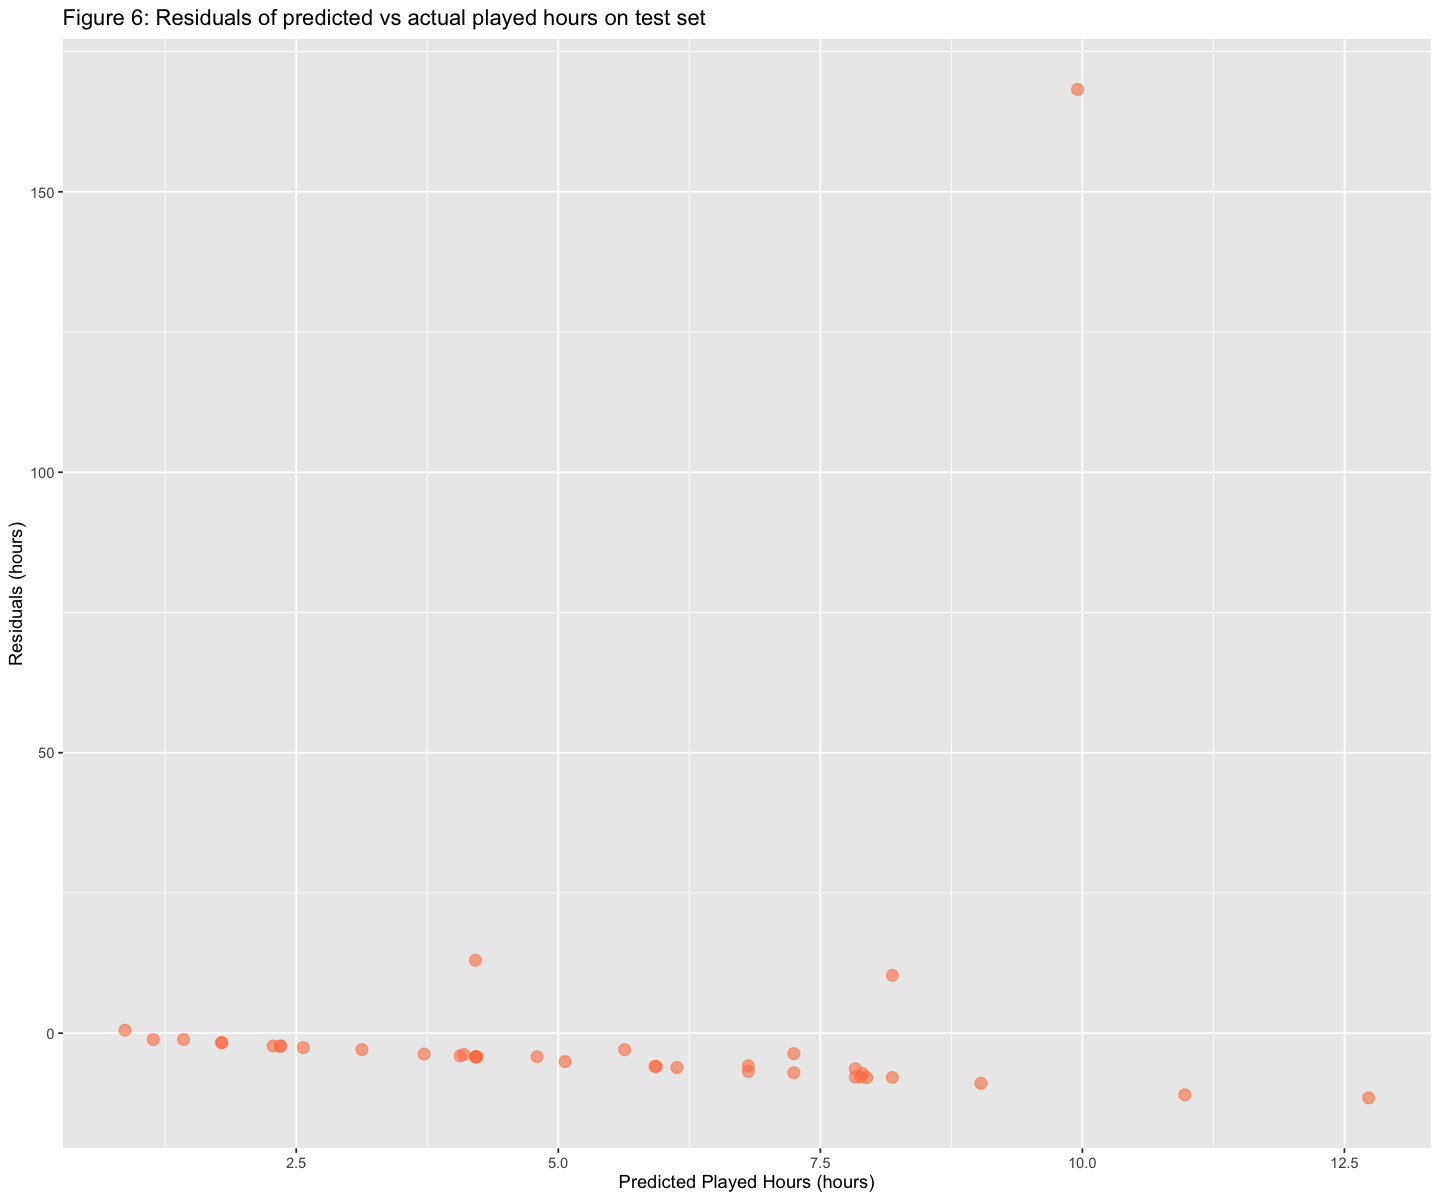

In [114]:
# visualization of residuals
residuals_plot <- test_predictions |>
    mutate(residual = played_hours - .pred) |>
    ggplot(aes(x = .pred, y = residual)) +
    geom_point(alpha = 0.6, size = 3, color = "coral") +
    labs(
        title = "Figure 6: Residuals of predicted vs actual played hours on test set",
        x = "Predicted Played Hours (hours)",
        y = "Residuals (hours)"
    )

residuals_plot

_Figure 6_ displays residuals ($\text{actual} - \text{predicted hours}$) against predicted values. Ideally, residuals should cluster randomly around zero with no systematic patterns.
- The majority of points cluster near zero residual with predicted values between 2–13 hours. This is somewhat misleading. It largely reflects that most players have near-zero actual playtime, so predicting 5–10 hours for everyone produces small absolute errors for the majority.
- Looking at the pattern of variance, the residual increases as the predicted hours increases. This suggests the model's uncertainty grows for players it expects to be more engaged. We also observe three distinct outliers with large positive residuals, indicating the model systematically underpredicts for high-engagement players.
- So, the model captures average behavior reasonably well but fails to identify the subset of players who will become highly engaged (arguably the most valuable segment to predict accurately).

## Discussion:
<!-- - summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to -->

To summarize, we developed a K-NN regression model to predict total hours played on the PLAIcraft server using player demographic characteristics (age, gender, experience level, and newsletter subscription status). The model was trained on 80% of the data (155 players) and evaluated on an unseen test set of 20% (39 players).

Through 5-fold cross-validation testing K values from 1 to 50, we identified the optimal number of neighbors as K = 48. The final model achieved a test set RMSE of 27.26 hours and an R-squared of 0.074 (7.4%).

### Model performance

We found that demographic characteristics have very weak predictive power for player engagement. With an $R^2$ value of only 7.4%, the model explains less than 8% of the variance in played hours, meaning over 92% of the variation in player engagement remains unexplained by demographic factors.

_Figure 5a_ illustrates this limitation. While the model makes predictions in a reasonable range for most players (5-15 hours), it doesn't accurately predict high-engagement outliers. For instance, the player who contributed over 200 hours is predicted to play only about 10 hours. _Figure 5b_ shows that even within the typical range (0-20 hours), predictions show substantial scatter around the ideal diagonal ($y = x$) line.

Given that the mean playtime is only 5.9 hours and the median is 0.1 hours, the RMSPE of 27.26 hours means the typical prediction error is nearly 5 times larger than the average actual playtime, which makes individual predictions not so useful for recruitment decisions.

### Comparison to initial hypothesis

This contradicts our initial hypothesis. The exploratory data analysis (in _Figure 3_) suggested that younger players and certain experience levels might be associated with higher engagement. We expected that systematically combining these demographic signals would yield at least moderate predictive power (perhaps R² > 0.3).

Several factors likely contributed to this:
- **Right-skewed distribution**. The strong right skew in played hours (_Figure 2_) means most players contribute minimal data regardless of demographics, while a few outliers contribute disproportionately. K-NN regression, which averages neighbors' values, may then struggle to predict rare extreme values.
- **Low quality predictors**. Demographics may simply not be the relevant variables. Engagement might depend more on factors not captured in this dataset, like individual factors (personal interest, social connections, available free time), specific gameplay interests, prior Minecraft experience quality (not just self-reported level), or recruitment source.

### Implications

While the model has limited predictive utility, we can glean that:
- The PLAIcraft team should not rely on demographic targeting for recruitment. And since demographics don't predict who will engage, the team should instead focus on mechanisms to increase engagement among all recruits, like community building, prizes, or clear communication about research goals.
- The high proportion of zero/low-playtime registrations (median = 0.1 hours) suggests engagement is better framed as two questions: (1) will a registered player actually log in? and (2) among those who log in, how much will they play? A classification model for question (1) might perform better than regression on combined data.

### Future research

Extending this research, we could explore:
- **Behavioral and social predictors** from the `sessions.csv` dataset as potential better predictors:
   - First-session duration - strong early engagement might predict long-term engagement
   - Time-of-day preferences - players joining during off-peak hours might be more committed
   - Social network formation - players who make friends early might stay longer
   - Achievement progression rates
  
- **Classification before regression** using the two-stage model described earlier:
   - Stage 1: predict whether a registered player will actually play (classification)
   - Stage 2: among players who engage, predict how much they'll play (regression)
   This approach might better match the data structure where most players contribute zero hours.

### Conclusion

This study answers the research question, but not in the way we initially hoped. Player demographic characteristics (age, gender, experience level, newsletter subscription) does not reliably predict total hours played on the PLAIcraft server. While this limits the model's usefulness to the wider question, it tells the PLAIcraft team that demographic targeting probably won't improve recruitment efficiency and that resources should be directed toward other engagement tactics.

# References
Lee, T. T., Trevor Campbell, and Melissa. (2024). Chapter 7 Regression I: K-nearest neighbors | Data Science. https://datasciencebook.ca/regression1.html

tidymodels contributors. (n.d.-a). Add new variables using dplyr—Step_mutate. Retrieved December 2, 2025, from https://recipes.tidymodels.org/reference/step_mutate.html

tidymodels contributors. (n.d.-b). Create traditional dummy variables—Step_dummy. Retrieved December 2, 2025, from https://recipes.tidymodels.org/reference/step_dummy.html


In [126]:
# count words in all markdown cells of this notebook
suppressPackageStartupMessages({
  ok_jsonlite <- require(jsonlite, quietly = TRUE)
  ok_stringr  <- require(stringr, quietly = TRUE)
})

# simple helper for NULL-coalescing (define before use)
`%||%` <- function(a, b) if (is.null(a)) b else a

# resolve path to this notebook
path <- "final-project.ipynb"
if (!file.exists(path)) {
  path <- "final-project.ipynb"
}
if (!file.exists(path)) stop("wrong path")

# read the notebook JSON
nb <- jsonlite::read_json(path, simplifyVector = FALSE)
cells <- nb$cells

# identify markdown cells and collect their text
md_idx <- which(vapply(cells, function(x) identical(x$cell_type, "markdown"), logical(1)))
md_texts <- lapply(cells[md_idx], function(x) paste0(x$source %||% "", collapse = "\n"))

# word counting function with light markdown cleanup
count_words <- function(text) {
  text <- stringr::str_replace_all(text, "\\r", "\n")
  # remove comments: HTML comments and common Markdown comment syntaxes
  text <- stringr::str_remove_all(text, stringr::regex("<!--.*?-->", dotall = TRUE))
  text <- stringr::str_remove_all(text, "(?m)^\\[//\\]:\\s*#\\s*\\(.*?\\)\\s*$")
  text <- stringr::str_remove_all(text, "(?m)^\\[comment\\]:\\s*<>\\s*\\(.*?\\)\\s*$")
  # convert links/images to just their alt/text
  text <- stringr::str_replace_all(text, "!\\[([^\\]]*)\\]\\([^\\)]+\\)", "\\1")
  text <- stringr::str_replace_all(text, "\\[([^\\]]+)\\]\\([^\\)]+\\)", "\\1")
  # remove HTML tags and code ticks
  text <- stringr::str_replace_all(text, "<[^>]+>", " ")
  text <- stringr::str_replace_all(text, "`+", " ")
  # remove heading/bullet markers at line starts
  text <- stringr::str_replace_all(text, "(?m)^[#>\\-\\*\\+]+\\s*", " ")
  # extract word-like tokens (letters, numbers, hyphen, apostrophe) using unicode classes
  toks <- stringr::str_extract_all(text, "\\b[\\p{L}][\\p{L}\\p{N}'-]*\\b", simplify = FALSE)[[1]]
  length(toks)
}

counts <- vapply(md_texts, count_words, integer(1))

cat(sprintf("\nTotal words across markdown cells: %d\n", sum(counts)))

word_counts <- tibble::tibble(cell_number = md_idx, word_count = counts)
word_counts



Total words across markdown cells: 1714


cell_number,word_count
<int>,<int>
1,28
3,1
4,147
⋮,⋮
42,1
43,624
44,57
